In [103]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
train_csv = pd.read_csv("train_data.csv")
validation_csv = pd.read_csv("validation_data.csv")
test_csv = pd.read_csv("test_data.csv")

In [3]:
train_csv.head()

,school,failures,Dalc,Walc,absences,Avg Grade of 3 Period
0,GP,0,1,1,6,5.666667
1,GP,0,1,1,4,5.333333
2,GP,3,2,3,10,8.333333
3,GP,0,1,1,2,14.666667
4,GP,0,1,2,4,8.666667


In [100]:

# For the features, select all rows and all columns except the last one
X_train = train_csv.iloc[:, :-1]

# For the target variable, select all rows and only the last column
y_train = train_csv.iloc[:, -1]

# If 'school' is a categorical variable, convert it using one-hot encoding
X_train = pd.get_dummies(X_train, columns=['school'])
# Initialize the Random Forest Regressor
# rf = RandomForestRegressor(n_estimators=100, random_state=30)

# # Train the model on the training data
# rf.fit(X_train, y_train)

# Evaluate the model on the validation data
X_validation = validation_csv.iloc[:, :-1]
y_validation = validation_csv.iloc[:, -1]
X_validation = pd.get_dummies(X_validation, columns=['school'])



# Predict on test data (you would do this after finalizing the model)
X_test = test_csv.iloc[:, :-1]
y_test = test_csv.iloc[:,-1]
X_test = pd.get_dummies(X_test, columns=['school'])


Best n_estimators: 180
Best Validation MSE: 13.456942195792866


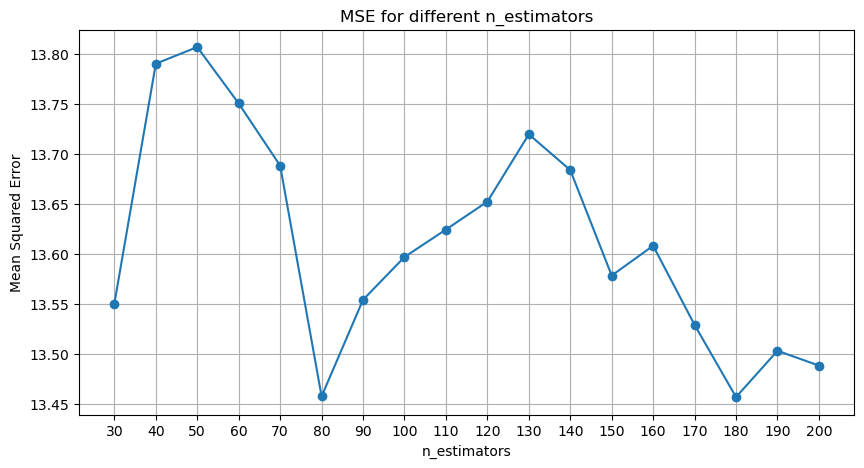

Final Model Test MSE: 13.456942195792866


In [101]:
# Assuming the data is already prepared and available in X_train, y_train, X_validation, y_validation
# Initialize variables to store the best hyperparameters and corresponding score
best_n_estimators = 0
best_mse = np.inf
mse_scores = []

# Tune the 'n_estimators' hyperparameter
for n in range(30, 210, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store the score
    mse_scores.append(mse)
    
    # Update the best parameters if current MSE is lower than the best MSE
    if mse < best_mse:
        best_mse = mse
        best_n_estimators = n

# Print the best hyperparameters and their corresponding MSE
print(f'Best n_estimators: {best_n_estimators}')
print(f'Best Validation MSE: {best_mse}')

# Plot the MSE scores for each value of n_estimators
plt.figure(figsize=(10, 5))
plt.plot(range(30, 210, 10), mse_scores, marker='o')
plt.title('MSE for different n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.xticks(range(30, 210, 10))
plt.grid(True)
plt.show()

# Train the final model with the best hyperparameter
final_model = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test set
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
print(f'Final Model Test MSE: {final_mse}')

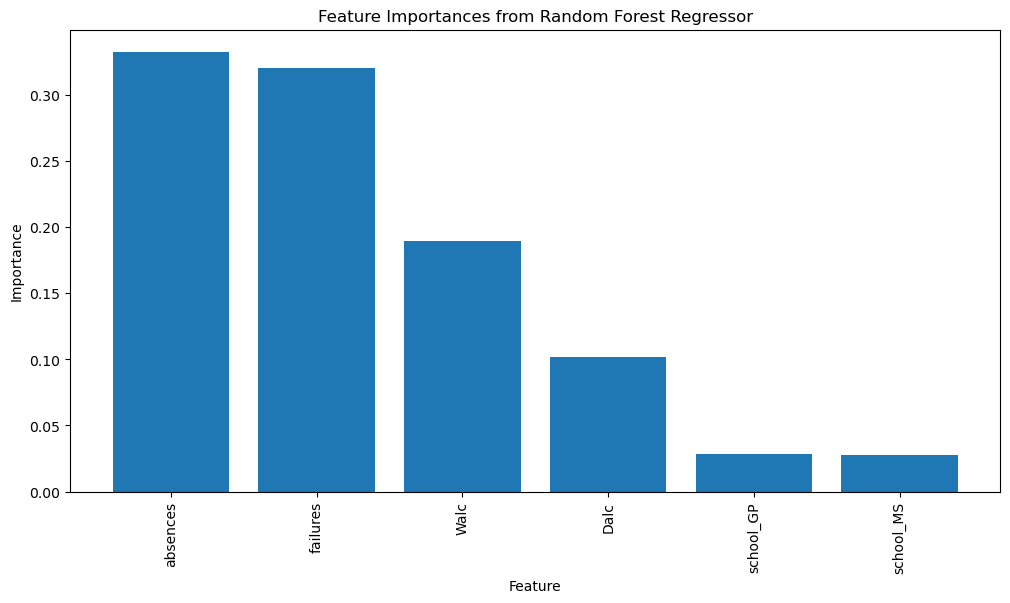

In [102]:
# Get feature importances from the best model
feature_importances = final_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances from Random Forest Regressor')
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [6]:
# Define a dataset class
class RegressionDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [14]:
# Assuming your data is in train_csv and test_csv DataFrames and normalized if necessary
# Convert to numpy arrays
X_train_values = X_train.values.astype(np.float32)
y_train_values = y_train.values.astype(np.float32).reshape(-1, 1)
X_validation_values = X_validation.values.astype(np.float32)
y_validation_values = y_validation.values.astype(np.float32).reshape(-1,1)
X_test_values = X_test.values.astype(np.float32)
y_test_values = y_test.values.astype(np.float32).reshape(-1, 1)

In [15]:
# Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_values)
# X_validation_values = scaler.fit_transform(X_validation_values)
# Create datasets
train_dataset = RegressionDataset(torch.tensor(X_train_values), torch.tensor(y_train_values))
val_dataset = RegressionDataset(torch.tensor(X_validation_values), torch.tensor(y_validation_values))
test_dataset = RegressionDataset(torch.tensor(X_test_values), torch.tensor(y_test_values))

In [16]:
# Define the neural network structure
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 64)  # 64 neurons in the first hidden layer
        self.fc2 = nn.Linear(64, 32)          # 32 neurons in the second hidden layer
        self.fc3 = nn.Linear(32, 1)           # Output layer
        self.dropout = nn.Dropout(0.1)        # Dropout layer for regularization
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)                   # Apply dropout
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)                   # Apply dropout
        x = self.fc3(x)
        return x

Epoch 1/100, Train Loss: 118.76158650716145, Val Loss: 108.28224563598633
Epoch 2/100, Train Loss: 104.64595540364583, Val Loss: 91.74267578125
Epoch 3/100, Train Loss: 88.4002448187934, Val Loss: 77.3889217376709
Epoch 4/100, Train Loss: 73.38777626885309, Val Loss: 71.42688369750977
Epoch 5/100, Train Loss: 61.73132832845052, Val Loss: 74.41971111297607
Epoch 6/100, Train Loss: 54.80918078952365, Val Loss: 75.11342906951904
Epoch 7/100, Train Loss: 52.244458728366425, Val Loss: 70.76051330566406
Epoch 8/100, Train Loss: 46.60861163669162, Val Loss: 57.67879772186279
Epoch 9/100, Train Loss: 42.81935713026259, Val Loss: 47.7950496673584
Epoch 10/100, Train Loss: 38.73420185512967, Val Loss: 41.27757263183594
Epoch 11/100, Train Loss: 33.491555743747284, Val Loss: 37.73738098144531
Epoch 12/100, Train Loss: 32.34636773003472, Val Loss: 35.39546203613281
Epoch 13/100, Train Loss: 30.121799892849392, Val Loss: 32.56534004211426
Epoch 14/100, Train Loss: 29.080504099527996, Val Loss: 30.9

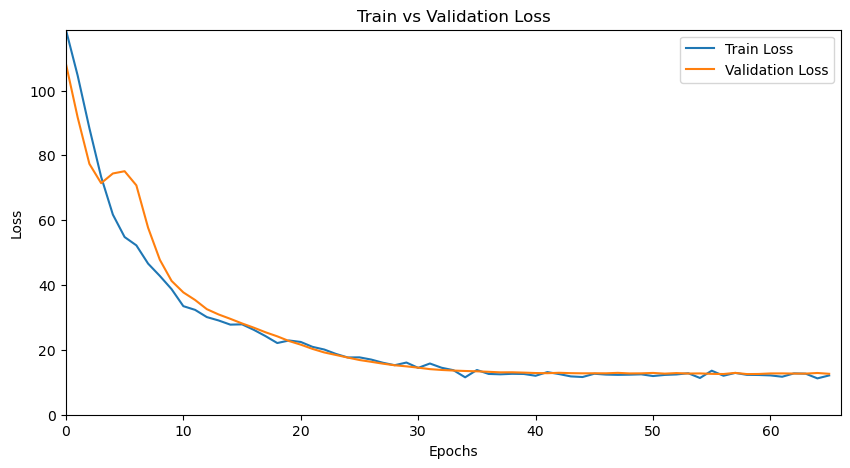

In [37]:
# Initialize the model
# model = Net(X_train_scaled.shape[1])
model = Net(X_train_values.shape[1])

# Choose Mean Squared Error Loss function for regression
criterion = nn.MSELoss()

# Choose the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
# Early stopping parameters
patience = 10
min_delta = 0.1
best_loss = np.inf
counter = 0
early_stop = False

# Initialize lists for tracking losses
train_losses = []
val_losses = []

# Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_losses = []  # List to store losses for each batch in the epoch
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate loss
        loss = criterion(outputs, targets.view(-1, 1))
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    # Record the average training loss for this epoch
    avg_train_loss = np.mean(epoch_losses)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    val_epoch_losses = []  # List to store losses for each batch in the validation data
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets.view(-1, 1))
            val_epoch_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_epoch_losses)
    
    val_losses.append(avg_val_loss)  # Record the average validation loss for this epoch
    
    # Early stopping check
    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            early_stop = True
            break
    
    # Print statistics
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

    if early_stop:
        print("Stopped early due to increasing validation loss.")
        break

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, len(train_losses))
plt.ylim(0, max(max(train_losses), max(val_losses)))
plt.legend()
plt.show()

In [40]:
model.eval()
test_losses = []
with torch.no_grad():
    for inputs, targets in test_loader:
        # Make predictions
        outputs = model(inputs)
        # Compute loss
        test_loss = criterion(outputs, targets.view(-1, 1))
        test_losses.append(test_loss.item())

# Calculate the average loss over all the test set
avg_test_loss = np.mean(test_losses)
print(f'Average Test Loss: {avg_test_loss}')

Average Test Loss: 12.828926086425781


[10.66666667, 3.666666667, 5.333333333, 9.666666667, 5.666666667, 4.0, 6.333333333, 8.666666667, 13.66666667, 15.66666667, 11.0, 10.66666667, 13.66666667, 17.33333333, 14.0, 12.66666667, 17.66666667, 8.333333333, 13.0, 10.66666667, 6.0, 13.0, 11.66666667, 11.33333333, 13.66666667, 11.66666667, 5.333333333, 9.333333333, 10.66666667, 11.0, 13.0, 9.666666667, 11.0, 13.66666667, 15.33333333, 10.66666667, 15.0, 10.33333333, 9.333333333, 14.0, 8.333333333, 13.33333333, 2.333333333, 5.333333333, 6.333333333, 15.33333333, 13.33333333, 5.0, 16.0, 9.666666667, 11.33333333, 6.666666667, 15.33333333, 5.666666667, 10.33333333, 13.33333333, 15.66666667, 9.666666667, 14.33333333]
[11.62549877166748, 8.398308753967285, 9.791704177856445, 11.497406959533691, 10.629080772399902, 8.294597625732422, 10.82489013671875, 10.690010070800781, 11.29127025604248, 11.694493293762207, 10.904353141784668, 10.97281551361084, 11.29127025604248, 11.299738883972168, 9.717177391052246, 9.635489463806152, 11.291270256042

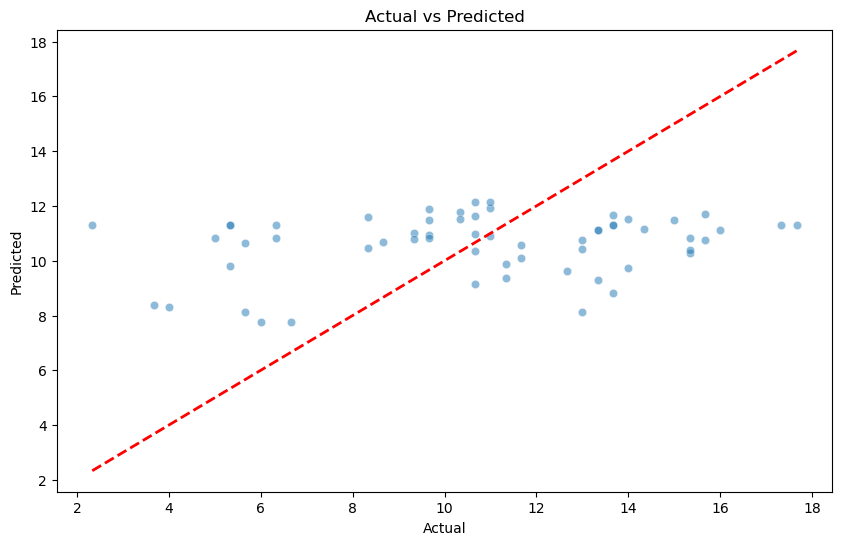

In [80]:
def plot_actual_vs_predicted(y_actual, y_predicted, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.5)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()
y_test_list = y_test.tolist()
predictions = model(torch.tensor(X_test_values).float())
predictions_list = predictions.cpu().detach().numpy().flatten().tolist()
print(y_test_list)
print(predictions_list)
plot_actual_vs_predicted(np.array(y_test_list),predictions_list,"Actual vs Predicted")

     failures  Dalc  Walc  absences  school_GP  school_MS
0           0     1     1         6          1          0
1           0     1     1         4          1          0
2           3     2     3        10          1          0
3           0     1     1         2          1          0
4           0     1     2         4          1          0
..        ...   ...   ...       ...        ...        ...
272         0     3     4         4          0          1
273         0     1     2         0          0          1
274         0     2     3        17          0          1
275         0     1     4         4          0          1
276         0     1     3         5          0          1

[277 rows x 6 columns]


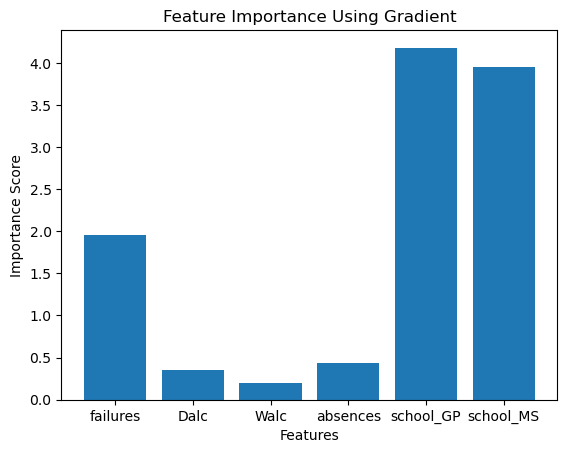

In [90]:
#sensitivity test for importance
def feature_importance(model, X):
    # Ensure model is in eval mode
    model.eval()

    # Convert X to a tensor if it's not already
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)
    
    # Perform a forward pass and get the prediction
    prediction = model(X_tensor)
    
    # Compute the gradient of the output with respect to the input
    prediction.backward(torch.ones_like(prediction))
    
    # Take the absolute value of the gradient as the importance score
    gradient_importance = X_tensor.grad.abs().mean(dim=0).detach().numpy()
    
    return gradient_importance

# Compute feature importance
importance_scores = feature_importance(model, X_train_values)
feature_names = ['failures', 'Dalc', 'Walc', 'absences', 'school_GP', 'school_MS']
# Now you can visualize the importance scores
plt.bar(feature_names, importance_scores)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance Using Gradient')
plt.show()